In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Barley',
    'Vinterbyg': 'Barley',
    'Grønkorn af vårbyg': 'Barley',
    'Vårbyg, helsæd': 'Barley',
    'Vinterhvede': 'Wheat',
    'Vårhvede': 'Wheat',
    'Vinterhybridrug': 'Rye',
    'Vårhavre': 'Oat',
    'Silomajs': 'Maize',
    'Majs til modenhed': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Sukkerroer til fabrik': 'Sugarbeet',
    'Permanent græs, normalt udbytte': 'Grass',
    'Skovdrift, alm.': 'Forest',
    'Juletræer og pyntegrønt på landbrugsjord': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 803 ms


In [5]:
ds.close()

time: 49.3 ms


In [6]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 36.1 s


In [ ]:
# Dicts to hold results
test_acc_logistic_regression = {'2018-07-01': 0}
classification_reports_logistic_regression = {}
trained_classifiers_logistic_regression = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression[end_date] = accuracy_test
    classification_reports_logistic_regression[end_date] = results_report 
    trained_classifiers_logistic_regression[end_date] = clf_trained 

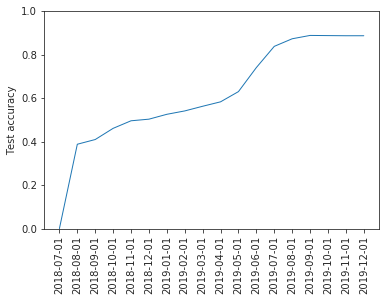

time: 188 ms


In [6]:
x = list(test_acc_logistic_regression.keys())
y = list(test_acc_logistic_regression.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [7]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 20.7 ms


In [8]:
# Dicts to hold results
test_acc_logistic_regression_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_balanced = {}
trained_classifiers_logistic_regression_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000, class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 3.754 s
Prediction time: 0.0037 s

Report:

Train accuracy: 0.2899
Test accuracy: 0.2939
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 10.4119 s
Prediction time: 0.0054 s

Report:

Train accuracy: 0.3513
Test accuracy: 0.3501
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 7.6181 s
Prediction time: 0.0053 s

Report:

Train accuracy: 0.4164
Test accuracy: 0.4163
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 15.0431 s
Prediction time: 0.005 s

Report:

Train accuracy: 0.4509
Test accuracy: 0.4475
--------------------------------

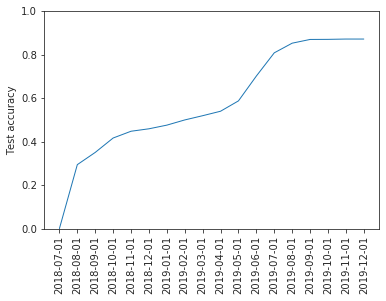

time: 180 ms


In [9]:
x = list(test_acc_logistic_regression_balanced.keys())
y = list(test_acc_logistic_regression_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [10]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 19.5 ms


In [11]:
# Dicts to hold results
test_acc_logistic_regression_cv = {'2018-07-01': 0}
classification_reports_logistic_regression_cv = {}
trained_classifiers_logistic_regression_cv = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv[end_date] = accuracy_test
    classification_reports_logistic_regression_cv[end_date] = results_report 
    trained_classifiers_logistic_regression_cv[end_date] = clf_trained 
    

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 26.1672 s
Prediction time: 0.0014 s

Report:

Train accuracy: 0.3795
Test accuracy: 0.3881
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time: 65.6315 s
Prediction time: 0.0015 s

Report:

Train accuracy: 0.4165
Test accuracy: 0.4103
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time: 83.6635 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.4657
Test accuracy: 0.4602
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 120.151 s
Prediction time: 0.0025 s

Report:

Train accuracy: 0.5014
Test accuracy: 0.4957
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-12-01
Training time: 121.4712 s
Prediction time: 0.0026 s

Report:

Train accuracy: 0.5159
Test accuracy: 0.5032
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-01-01
Training time: 125.8427 s
Prediction time: 0.0047 s

Report:

Train accuracy: 0.5342
Test accuracy: 0.5255
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-02-01
Training time: 137.1409 s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 170.1844 s
Prediction time: 0.0069 s

Report:

Train accuracy: 0.5945
Test accuracy: 0.5805
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-05-01
Training time: 171.4604 s
Prediction time: 0.0061 s

Report:

Train accuracy: 0.64
Test accuracy: 0.6293
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-06-01
Training time: 186.6096 s
Prediction time: 0.0056 s

Report:

Train accuracy: 0.7449
Test accuracy: 0.739
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-07-01
Training time: 187.2446 s
Prediction time: 0.0096 s

Report:

Train accuracy: 0.8392
Test accuracy: 0.8382
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-08-01
Training time: 200.0937 s
P

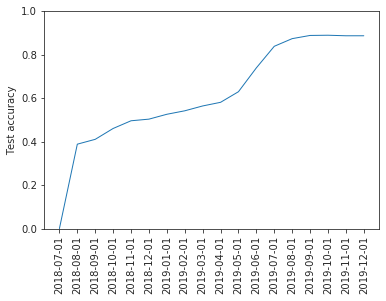

time: 179 ms


In [12]:
x = list(test_acc_logistic_regression_cv.keys())
y = list(test_acc_logistic_regression_cv.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [13]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 19.5 ms


In [14]:
# Dicts to hold results
test_acc_logistic_regression_cv_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_cv_balanced = {}
trained_classifiers_logistic_regression_cv_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000, 
                               class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_cv_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_cv_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 16.7954 s
Prediction time: 0.0013 s

Report:

Train accuracy: 0.2906
Test accuracy: 0.2931
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 31.0115 s
Prediction time: 0.0017 s

Report:

Train accuracy: 0.3507
Test accuracy: 0.3511
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 46.1217 s
Prediction time: 0.002 s

Report:

Train accuracy: 0.4171
Test accuracy: 0.4162
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 60.5283 s
Prediction time: 0.0027 s

Report:

Train accuracy: 0.4516
Test accuracy: 0.4475
-----------------------------

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 130.9137 s
Prediction time: 0.0061 s

Report:

Train accuracy: 0.5211
Test accuracy: 0.5189
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-04-01


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 178.5172 s
Prediction time: 0.0074 s

Report:

Train accuracy: 0.5529
Test accuracy: 0.5391
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-05-01


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 171.9591 s
Prediction time: 0.0055 s

Report:

Train accuracy: 0.5999
Test accuracy: 0.5908
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-06-01


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 179.5524 s
Prediction time: 0.0084 s

Report:

Train accuracy: 0.704
Test accuracy: 0.7008
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-07-01
Training time: 185.1559 s
Prediction time: 0.0096 s

Report:

Train accuracy: 0.815
Test accuracy: 0.8077
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-08-01
Training time: 193.105 s
Prediction time: 0.0072 s

Report:

Train accuracy: 0.8586
Test accuracy: 0.853
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-09-01
Training time: 207.9626 s
Prediction time: 0.0078 s

Report:

Train accuracy: 0.869
Test accuracy: 0.8689
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-10-01
Training time: 220.5663 s
Pre

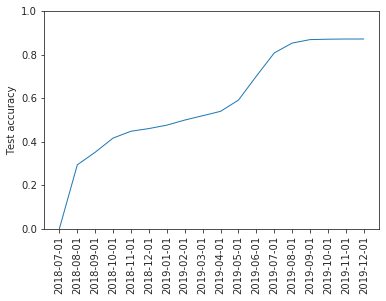

time: 203 ms


In [15]:
x = list(test_acc_logistic_regression_cv_balanced.keys())
y = list(test_acc_logistic_regression_cv_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [16]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.7 ms


In [17]:
# Dicts to hold results
test_acc_svm_linear = {'2018-07-01': 0}
classification_reports_svm_linear = {}
trained_classifiers_svm_linear = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear[end_date] = accuracy_test
    classification_reports_svm_linear[end_date] = results_report 
    trained_classifiers_svm_linear[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 87.1397 s
Prediction time: 11.2233 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.3557
Test accuracy: 0.3597
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 143.5077 s
Prediction time: 16.9089 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.4128
Test accuracy: 0.4064
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 165.4422 s
Prediction time: 20.6867 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.465
Test accuracy: 0.4576
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 192.3666 s
Prediction time: 26.9956 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.5088
Test accuracy: 0.4959
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-12-01
Training time: 212.4042 s
Prediction time: 30.6502 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.5269
Test accuracy: 0.5146
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-01-01
Training time: 270.5735 s
Prediction time: 39.2071 s

Report:

Train accuracy: 0.545
Test accuracy: 0.5353
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-02-01
Training time: 324.6944 s
Prediction time: 47.991 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.5636
Test accuracy: 0.5491
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-03-01
Training time: 425.8825 s
Prediction time: 54.6522 s

Report:

Train accuracy: 0.5811
Test accuracy: 0.5735
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-04-01
Training time: 561.1883 s
Prediction time: 60.6502 s

Report:

Train accuracy: 0.607
Test accuracy: 0.5893
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-05-01
Training time: 564.1843 s
Prediction time: 63.1017 s

Report:

Train accuracy: 0.6574
Test accuracy: 0.6424
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-06-01
Training time: 313.6423 s
Prediction time: 55.4447 s

Report:

Train accur

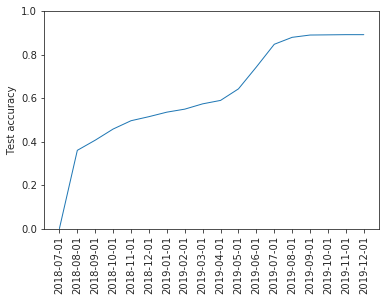

time: 172 ms


In [18]:
x = list(test_acc_svm_linear.keys())
y = list(test_acc_svm_linear.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [19]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.4 ms


In [20]:
# Dicts to hold results
test_acc_svm_linear_balanced = {'2018-07-01': 0}
classification_reports_svm_linear_balanced = {}
trained_classifiers_svm_linear_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear_balanced[end_date] = accuracy_test
    classification_reports_svm_linear_balanced[end_date] = results_report 
    trained_classifiers_svm_linear_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 99.1608 s
Prediction time: 11.097 s

Report:

Train accuracy: 0.2998
Test accuracy: 0.3028
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 146.7442 s
Prediction time: 15.9059 s

Report:

Train accuracy: 0.3605
Test accuracy: 0.3592
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 157.1282 s
Prediction time: 19.1062 s

Report:

Train accuracy: 0.4274
Test accuracy: 0.4279
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 187.7026 s
Prediction time: 24.1891 s

Report:

Train accuracy: 0.4663
Test accuracy: 0.4579
----------------------

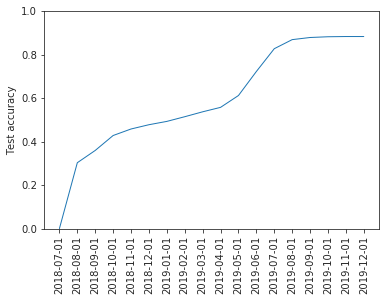

time: 167 ms


In [21]:
x = list(test_acc_svm_linear_balanced.keys())
y = list(test_acc_svm_linear_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [22]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 19 ms


In [23]:
# Dicts to hold results
test_acc_svm_rbf = {'2018-07-01': 0}
classification_reports_svm_rbf = {}
trained_classifiers_svm_rbf = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf[end_date] = accuracy_test
    classification_reports_svm_rbf[end_date] = results_report 
    trained_classifiers_svm_rbf[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 86.8391 s
Prediction time: 19.7716 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.427
Test accuracy: 0.424
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 98.0218 s
Prediction time: 26.9489 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.5001
Test accuracy: 0.4667
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 97.2874 s
Prediction time: 31.4877 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.5733
Test accuracy: 0.5332
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 105.7836 s
Prediction time: 37.9078 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Report:

Train accuracy: 0.6181
Test accuracy: 0.5757
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-12-01
Training time: 111.1802 s
Prediction time: 41.5606 s

Report:

Train accuracy: 0.6402
Test accuracy: 0.591
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-01-01
Training time: 136.0314 s
Prediction time: 49.2438 s

Report:

Train accuracy: 0.6623
Test accuracy: 0.6062
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-02-01
Training time: 143.1201 s
Prediction time: 57.7894 s

Report:

Train accuracy: 0.6793
Test accuracy: 0.6223
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2019-03-01
Training time: 164.4566 s
Prediction time: 64.2862 s

Report:

Train accur

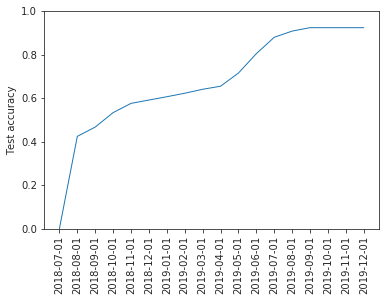

time: 167 ms


In [24]:
x = list(test_acc_svm_rbf.keys())
y = list(test_acc_svm_rbf.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [25]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.2 ms


In [26]:
# Dicts to hold results
test_acc_svm_rbf_balanced = {'2018-07-01': 0}
classification_reports_svm_rbf_balanced = {}
trained_classifiers_svm_rbf_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf_balanced[end_date] = accuracy_test
    classification_reports_svm_rbf_balanced[end_date] = results_report 
    trained_classifiers_svm_rbf_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 104.128 s
Prediction time: 18.7846 s

Report:

Train accuracy: 0.3447
Test accuracy: 0.336
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 119.2407 s
Prediction time: 26.2293 s

Report:

Train accuracy: 0.4469
Test accuracy: 0.4141
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 118.686 s
Prediction time: 30.2421 s

Report:

Train accuracy: 0.52
Test accuracy: 0.486
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 128.6466 s
Prediction time: 36.8031 s

Report:

Train accuracy: 0.5674
Test accuracy: 0.5274
--------------------------

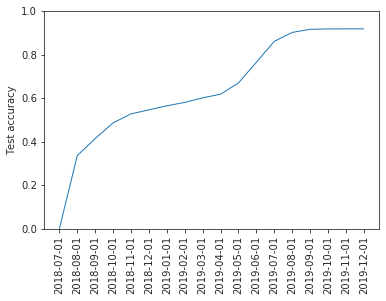

time: 169 ms


In [27]:
x = list(test_acc_svm_rbf_balanced.keys())
y = list(test_acc_svm_rbf_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [28]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.1 ms


In [ ]:
# Dicts to hold results
test_acc_svm_rbf_cv = {'2018-07-01': 0}
classification_reports_svm_rbf_cv = {}
trained_classifiers_svm_rbf_cv = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    param_grid = {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    #clf = SVC(kernel='rbf')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    print(f"The best parameters are {clf_trained.best_params_} with a score of {clf_trained.best_score_:2f}")
    
    test_acc_svm_rbf_cv[end_date] = accuracy_test
    classification_reports_svm_rbf_cv[end_date] = results_report 
    trained_classifiers_svm_rbf_cv[end_date] = clf_trained 
    
    # Idea: Maybe make a utils folder, with a plotting module, evaluation module etc.. The below here should 
    #       then be put in the plotting module. 
    mean_test_scores = clf_trained.cv_results_['mean_test_score']
    mean_fit_times = clf_trained.cv_results_['mean_fit_time']
    param_columns = list(clf_trained.cv_results_['params'][0].keys())
    result_columns = ['mean_fit_time', 'mean_test_score']
    num_fits = len(clf_trained.cv_results_['params'])

    df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
    for i, param_set in enumerate(grid_trained.cv_results_['params']):
        for param, value in param_set.items():
            df_cv_results.loc[i, param] = value 
        df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
        df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]

    df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
    plt.figure(figsize=(10,8))
    ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

    df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
    plt.figure(figsize=(10,8))
    ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01


In [ ]:
x = list(test_acc_svm_rbf_cv.keys())
y = list(test_acc_svm_rbf_cv.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)